# Revisit all permutations sound paradigm with the new metrics
The last iteration of my experiments have used an stimulation paramete which I have called triplet
(three sound fragments coming from the same source) which enables the comparison between sounds with multiple
degrees of difference. This however limits the diversity of sounds used for stimulation. In the past
I have used four different sounds and consider all the permutations between them used as context and probes
This was somewhat replaced by the triplets approach, but keep recording some data with this paradigm.

It is time to analyse this data with the latest metrics for contextual effects: significant absolute sum
and significant absolute mass center

furthermore, since the all permutations dataset has a "balanced" number of trials for al combinations of contexts and
probes, it enables running the dPCA algorithm not only using the context as a category for a given probe
(probewise dPCA or pdPCA), bur rather using all the contexts and probes simultaneously (full dPCA or fdPCA) as two
different categories.

This in particular gives us  multiple marginalizations (the projections on different subspaces) that better explain
variance across contexts, probes, or the interaction of both.

to do:
1. load DF, check general distribution of cells in paramter space


In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

import src.visualization.fancy_plots as fplt
from src.data.cache import set_name
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
import src.data.dPCA as cdPCA
from src.data.load import load
from src.metrics.dprime import flip_dprimes

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-12-23 135143.log


In [2]:
plt.style.use('dark_background')
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }
plt.rcParams.update(params)


# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#a65628',
#                   '#984ea3', '#999999', '#e41a1c', '#dede00']

trans_color_map = {0: '#377eb8',  # blue
                   1: '#ff7f00',  # orange
                   2: '#4daf4a',  # green
                   3: '#a65628', # brown
                   4: '#984ea3'}  # brown

prob_style_map = {1: '-',
                  2: '--',
                  3: ':',
                  4: '-.'}


In [3]:
config = ConfigParser()
config.read_file(open(pl.Path().cwd().parent / 'config' / 'settings.ini'))

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': [0, 1, 2, 3, 4],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

In [4]:
# loads the summary metrics
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'prm_summary_DF_v2' / set_name(meta)

DF = jl.load(summary_DF_file)

#create the id_probe pair for
DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)

In [5]:
print(DF.columns)
print(DF.head(5))

Index(['analysis', 'cellid', 'goodness', 'parameter', 'probe', 'siteid',
       'source', 'std', 'transition_pair', 'value', 'region', 'id_probe'],
      dtype='object')
  analysis        cellid  goodness parameter    probe   siteid  source  \
0       SC  AMT020a-02-1  0.007841        r0  probe_1  AMT020a  dprime   
1       SC  AMT020a-02-1  0.007841       tau  probe_1  AMT020a  dprime   
2       SC  AMT020a-02-1       NaN       max  probe_1  AMT020a  dprime   
3       SC  AMT020a-02-1       NaN  integral  probe_1  AMT020a  dprime   
4       SC  AMT020a-02-1       NaN       sum  probe_1  AMT020a  dprime   

         std transition_pair       value region              id_probe  
0   0.461871             0_1    0.651764     A1  AMT020a-02-1_probe_1  
1  52.036261             0_1   65.887210     A1  AMT020a-02-1_probe_1  
2        NaN             0_1    1.924205     A1  AMT020a-02-1_probe_1  
3        NaN             0_1 -145.514442     A1  AMT020a-02-1_probe_1  
4        NaN             

In [6]:
# load digested data
rec_recache = False
all_probes = [1, 2, 3, 4]

# load the calculated dprimes and montecarlo shuffling/simulations
# the loadede dictionary has 3 layers, analysis, value type and cell/site
batch_dprime_file = pl.Path(config['paths']['analysis_cache']) / 'prm_dprimes_v2' / set_name(meta)
batch_dprimes = jl.load(batch_dprime_file)

sites = set(batch_dprimes['pdPCA']['dprime'].keys())
all_cells = set(batch_dprimes['SC']['dprime'].keys())

In [7]:
# some small preprocessing of the digested data.
# defines a significant threshold and transform the pvalues into boolean (significant vs nonsignificant)
threshold = 0.01
for analysis_name, mid_dict in batch_dprimes.items():
    mid_dict['significance'] = {key: (val <= threshold) for key, val in mid_dict['pvalue'].items()}

# set up the time bin labels in milliseconds, this is critical for plotting and calculating the tau
nbin = np.max([value.shape[-1] for value in batch_dprimes['SC']['dprime'].values()])
fs = meta['raster_fs']
times = np.linspace(0, nbin / fs, nbin, endpoint=False) * 1000

bar_width = 1 / fs * 1000
fig_root = 'single_cell_context_dprime'

In [8]:
# functions taken/modified from 200221_exp_fit_SC_dPCA_LDA_examples.py

def analysis_steps_plot(id, probe, source):
    site = id[:7] if source == 'SC' else id

    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=False)
    sig = recs['perm0']['resp']
    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    if source in ['SC', 'pdPCA']:
        raw_data_probe = probe
    elif source == 'fdPCA':
        raw_data_probe = all_probes

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, raw_data_probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')
    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)

    if source != 'fdPCA':
        trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out singleton probe dimension

    # calculates dPCA projections, either probewise or full
    if source in ['pdPCA', 'fdPCA']:
        _, projection, _ = cdPCA._cpp_dPCA(R, trialR)
        projection = projection['ct'][:, 0, ...]

        if source == 'fdPCA':
            projection = projection[:,:,all_probes.index(probe),:]

    if meta['zscore'] is False:
        trialR = trialR * meta['raster_fs']
        if source in ['pdPCA', 'fdPCA']:
            projection = projection * meta['raster_fs']

    # flips signs of dprimes and montecarlos as needed
    dprimes, shuffleds = flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')

    t = times[:trialR.shape[-1]]
    fig, axes = plt.subplots(2, 10, sharex='all', sharey='row')

    #  PSTH
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        t0_idx = meta['transitions'].index(trans[0])
        t1_idx = meta['transitions'].index(trans[1])

        if source == 'SC':
            cell_idx = goodcells.index(id)
            axes[0, tt].plot(t, trialR[:, cell_idx, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]],
                             linewidth=3)
            axes[0, tt].plot(t, trialR[:, cell_idx, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]],
                             linewidth=3)
        else:
            axes[0, tt].plot(t, projection[:, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]], linewidth=3)
            axes[0, tt].plot(t, projection[:, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]], linewidth=3)

    # Raster, dprime, CI
    bottom, top = axes[0, 0].get_ylim()
    half = ((top - bottom) / 2) + bottom
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt

        if source == 'SC':
            # raster
            cell_idx = goodcells.index(id)
            t0_idx = meta['transitions'].index(trans[0])
            t1_idx = meta['transitions'].index(trans[1])

            _ = fplt._raster(t, trialR[:, cell_idx, t0_idx, :], y_offset=0, y_range=(bottom, half), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[0]], 'alpha': 0.4, 's': 10})
            _ = fplt._raster(t, trialR[:, cell_idx, t1_idx, :], y_offset=0, y_range=(half, top), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[1]], 'alpha': 0.4, 's': 10})

        # plots the real dprime and the shuffled dprime ci
        axes[1, tt].plot(t, dprimes[prb_idx, pair_idx, :], color='white')
        _ = fplt._cint(t, shuffleds[:, prb_idx, pair_idx, :], confidence=0.95, ax=axes[1, tt],
                       fillkwargs={'color': 'white', 'alpha': 0.5})

    # significance bars
    ax1_bottom = axes[1, 0].get_ylim()[0]

    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt
        # histogram of context discrimination
        axes[1, tt].bar(t, batch_dprimes[source]['significance'][id][prb_idx, pair_idx, :],
                        width=bar_width, align='center', color='gray', edgecolor='white', bottom=ax1_bottom)

        # formats legend
        if tt == 0:
            if source == 'SC':
                axes[0, tt].set_ylabel(f'z-score')
            elif source in ['pdPCA', 'fdPCA']:
                axes[0, tt].set_ylabel(f'{source}\nprojection')
            axes[1, tt].set_ylabel(f'dprime')
            axes[-1, tt].set_xlabel('time (ms)')

        axes[0, tt].set_title(f'C{trans[0]}_C{trans[1]}')

        for ax in np.ravel(axes):
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    return fig, axes

def dPCA_site_summary(site, probe, source, marginalizations):
    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=rec_recache)
    sig = recs['perm0']['resp']

    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    if source == 'pdPCA':
        raw_data_probe = [probe]
    elif source == 'fdPCA':
        raw_data_probe = all_probes

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, raw_data_probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')

    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)

    if source == 'pdPCA': trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out probe
    Z, trialZ, dpca = cdPCA._cpp_dPCA(R, trialR)

    fig, axes = plt.subplots(len(marginalizations), 3, sharex='all', sharey='row', squeeze=False)

    for mm, marg in enumerate(marginalizations):

        if source  == 'pdPCA':
            means = Z[marg][:,:,None,:]
            trials = trialZ[marg][:,:,:,None,:]
        if source  == 'fdPCA':
            means = Z[marg]
            trials = trialZ[marg]

        if marg == 'pt':
            marginalization = 'probe'
        elif marg == 'ct':
            marginalization = 'context'
        elif marg == 'cpt':
            marginalization = 'interaction'
        elif marg == 't':
            marginalization = 'time'
        else:
            marginalization = marg

        for pc in range(3):  # first 3 principal components

            ax = axes[mm, pc]

            for (tt, trans), (pp, prb) in itt.product(enumerate(meta['transitions']), enumerate(raw_data_probe)):  # for each context
                ax.plot(times, means[pc, tt, pp, :], label=trans, color=trans_color_map[trans],
                        linestyle = prob_style_map[prb],linewidth=2)

            # formats axes labels and ticks
            if pc == 0 :
                ax.set_ylabel(f'{marginalization} dependent\nfiring rate (z-score)')
            if mm == 0:
                ax.set_title(f'dPC #{pc + 1}')
            elif mm == len(marginalizations)-1:
                ax.set_xlabel('time (ms)')

        # legend in last axis
        # axes[-1, -1].legend(fontsize='x-large', markerscale=10,)

    return fig, ax, dpca, R


first explore which cells and sites have the highest value for contextual integration and duration. then uses said sites
as examples

In [29]:
# finds the unit-probe combination and site with the highest absolute integral and hopefully center of mass

ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_trans = DF.transition_pair != 'mean'
ff_probe = DF.probe != 'mean'

# single cell
print('\nsignle cell\n')
ff_analysis = DF.analysis=='SC'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['cellid', 'probe'], columns='parameter', values='value')
single_cell_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(10)
print(single_cell_top)

# probewise population
print('\nprobewise dPCA\n')
ff_analysis = DF.analysis=='pdPCA'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['siteid', 'probe'], columns='parameter', values='value')
pdPCA_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(10)
print(pdPCA_top)

# all probes population
print('\nfull dPCA\n')
ff_analysis = DF.analysis=='fdPCA'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['siteid', 'probe'], columns='parameter', values='value')
fdPCA_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(10)
print(fdPCA_top)


signle cell

parameter             significant_abs_mass_center  significant_abs_sum
cellid       probe                                                    
CRD004a-39-2 probe_4                   127.210370           453.847306
             probe_1                    84.440455           383.058747
CRD012b-13-1 probe_3                   476.057078           315.936593
CRD011c-50-4 probe_1                   161.468442           295.670369
             probe_4                   277.355808           280.256362
CRD004a-64-1 probe_2                   249.999713           254.348781
CRD004a-39-2 probe_2                    63.262196           245.338403
CRD011c-40-3 probe_4                   217.728535           244.096013
CRD011c-45-3 probe_1                   283.317353           236.017926
AMT029a-51-1 probe_2                    29.606065           232.836089

probewise dPCA

parameter        significant_abs_mass_center  significant_abs_sum
siteid  probe                                      

In [10]:
# this seems to be a good example cell and corresponding site
cell = 'CRD004a-39-2'
site = 'CRD004a'
probe = 1

### analysis steps
this particula example shows a combination of probe and cell/site where the cell does not show some sharp onset contextual
effect whith a relative sort duration, wich in comparison, last much longer when looking at the population analysis.
Aditionally, here we start seen that using pdPCA or fdPCA lead to similar results in the context marginalization space,
albeit with different amplitudes.

loading recording from box
SC, CRD004a-39-2 probe 1 calc steps
loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.009297222253682942
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please               

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


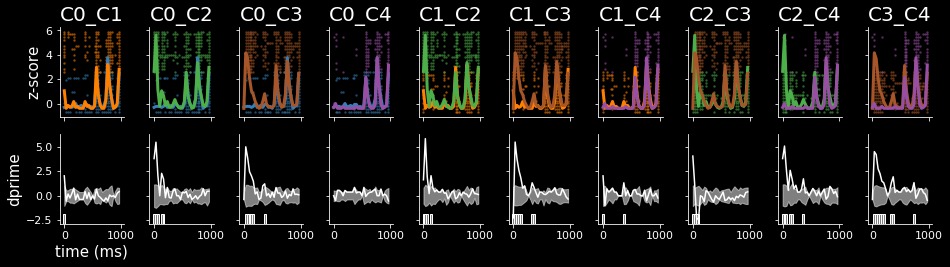

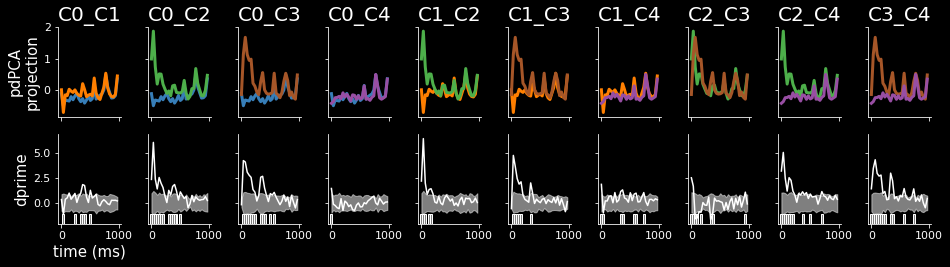

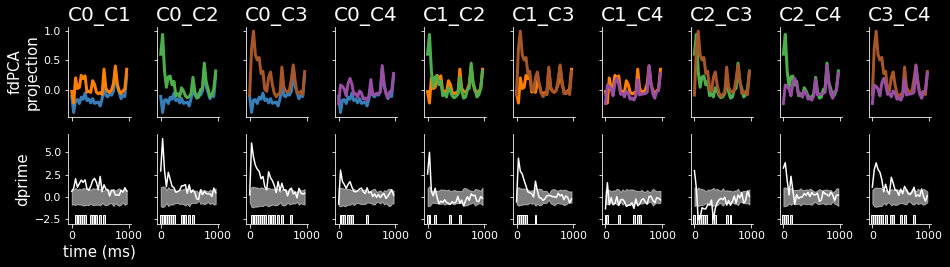

In [11]:
# SC examples
fig, axes = analysis_steps_plot(cell, probe, 'SC')
fig.set_size_inches(13.3, 3.81)
title = f'SC, {cell} probe {probe} calc steps'
print(title)
plt.show()

# pdPCA examples
fig, axes = analysis_steps_plot(site, probe, 'pdPCA')
fig.set_size_inches(13.3, 3.81)
title = f'pdPCA, {site} probe {probe}, calc steps'
print(title)
plt.show()

# fdPCA examples
fig, axes = analysis_steps_plot(site, probe, 'fdPCA')
fig.set_size_inches(13.3, 3.81)
title = f'fdPCA, {site} probe {probe}, calc steps'
print(title)
plt.show()

### detailed comparison of variance explained by pdPCA or fdPCA
we further confirm the similarity of results from fdPCA and pdPCA in their generale shape, however dpPCA amplitude tends
to be higher.

More importantly, the full dPCA unveils the relative contribution of contexts and probe to the responses. It is encouraging
that in this example the amplitude of the probe driven activity (~2) is not that much higher than the context generated
(~1.5). Of course while the former is see across the duration of the response, the later is restricted to the beginning
of the response and quickly decays.

The context_probe interaction marginalizations shows some values early on but is relatively smaller in amplitude that
the context and probe dependent marginalizations. While this is surprising, since i would expect context effects being
dependent on the general difference in sound statistics between context and probe, it is somewhat relieved, since said
interactions is difficult to explain.

non the less this interaction explains a fair amount of the context dependent response (~25%) so this further justifies
making an analysis of differences in sound features between probe and context, what might correlate to this interactions

loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.009297222253682942
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.
loading recording from b

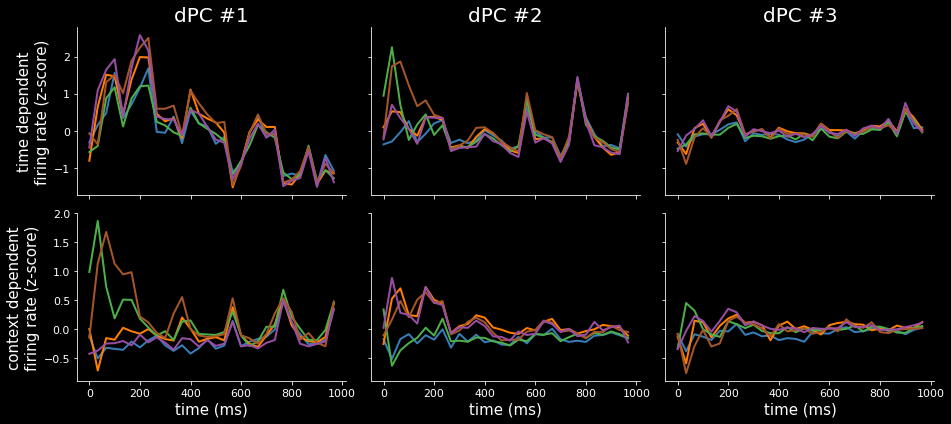

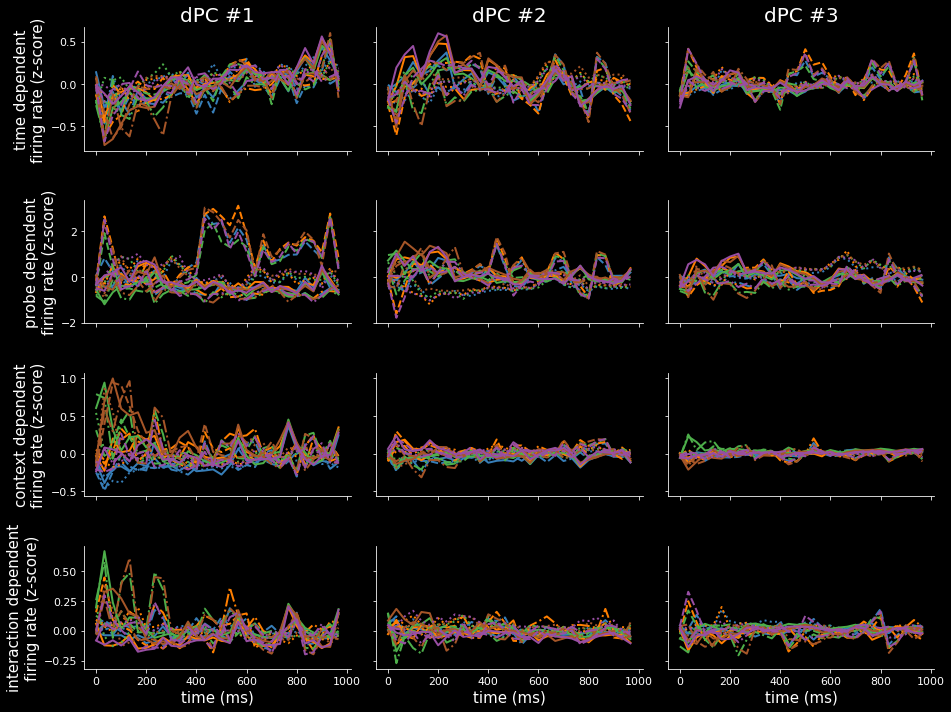

In [12]:
# probewise dPCA
fig1, axes, pdPCA, pR = dPCA_site_summary(site, probe, 'pdPCA', ['t', 'ct'])
fig1.set_size_inches((13.33, 6))
title = f'{site} probe-{probe} dPCA projection'
plt.show()


# full dPCA
fig1, axes, fdPCA, fR = dPCA_site_summary(site, all_probes, 'fdPCA', ['t', 'pt', 'ct', 'cpt'])
fig1.set_size_inches((13.33, 10))
title = f'{site} probe-{probe} dPCA projection'
plt.show()

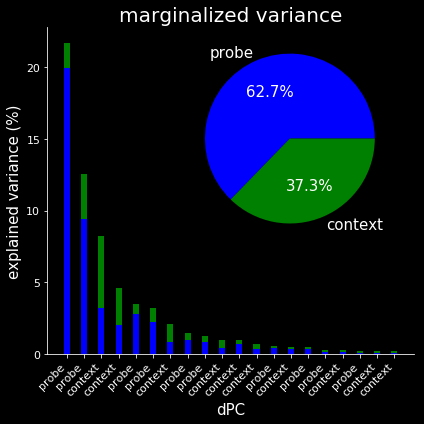

In [13]:
fig2, ax, inset = fplt.variance_captured(pdPCA, pR, ax=None, names={'t': 'probe', 'ct': 'context'}, colors=['blue', 'green'],
                                                  inset=True)
# fig2.set_size_inches((6, 3.6))
title = f'{site} probe-{probe} dPCA variance explained'
_, labels, autotexts = inset
plt.setp(autotexts, size=15, weight='normal')
plt.setp(labels, size=15, weight='normal')
ax.set_title('marginalized variance')
plt.show()

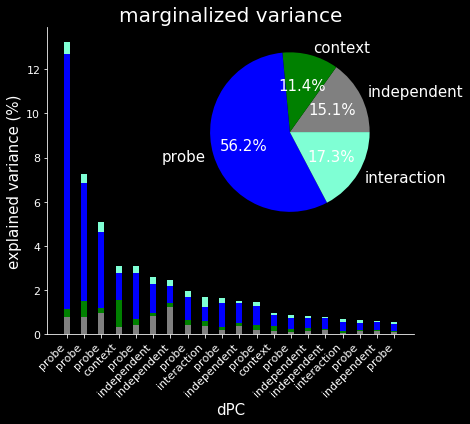

In [14]:

fig2, ax, inset = fplt.variance_captured(fdPCA, fR, ncomp=20, ax=None, names={'t': 'independent', 'ct': 'context', 'pt': 'probe', 'cpt':'interaction'},
                                          colors=['gray', 'green', 'blue', 'aquamarine'],inset=True)
# fig2.set_size_inches((6, 3.6))
title = f'{site} probe-{probe} dPCA variance explained'
_, labels, autotexts = inset
plt.setp(autotexts, size=15, weight='normal')
plt.setp(labels, size=15, weight='normal')
ax.set_title('marginalized variance')
plt.show()

interestingly, the context marginalization in this example is capturing the smallest amount of variation, however  if we
considere the interaction term it is a much better looking outcome. Indeed this is what we are capturing when doing
the analysis in a probe by probe manner. This specific example, 'CRD004a' comes from A1, which might justify why the probe
marginalization captures so much of the variation... however this come in contradiction of the fact that this site was
selected specifically for the amplitude and duration of the contextual effects it sowed.

# population metrics comparisons

## 1. cell and site distribution in parameter space

In [15]:
# functions taken and modiffied from 200823_center_of_mass_SC_dPCA.py
def parameter_space_scatter(x, y, analysis='SC', source='dprime', ax=None,
                            use_id_probe=False, color_regions=False):

    ff_parameter = DF.parameter.isin([x, y])
    ff_analysis = DF.analysis == analysis
    ff_source = DF.source == source
    if use_id_probe is True:
        ff_probe = DF.probe != 'mean'
    elif use_id_probe is False:
        ff_probe = DF.probe == 'mean'
    else:
        raise ValueError('use_id_probe must be boolean')

    ff_transpair= DF.transition_pair == 'mean'
    ff_good = np.logical_or(DF.goodness > 0.1, DF.goodness.isna()) # empirical good value to filter out garbage cells


    filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good,
                      ['id_probe', 'parameter', 'region', 'value']]
    pivoted = filtered.pivot_table(index=['id_probe', 'region'],
                                   columns='parameter', values='value').dropna().reset_index()

    if color_regions is True:
        g = sns.lmplot(x=x, y=y, hue='region', data=pivoted,
               ci=None, fit_reg=False)
        ax = g.ax
    elif color_regions is False:
        ax = sns.regplot(x=x, y=y, data=pivoted, ax=ax, color='white')
    else:
        raise ValueError('color_region must be bool')

    ax.axhline(0, linestyle='--')
    ax.axvline(0, linestyle='--')

    if use_id_probe is True:
        title = f'{analysis} {len(pivoted.index)} units'
    elif use_id_probe is False:
        title = f'{analysis} {len(pivoted.index)} probe_units'

    ax.set_title(fill(title, 35))
    fig = ax.get_figure()
    plt.show(fig)
    return fig, ax

def condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='SC',
                                  source='dprime',
                                  nan2zero=False, nozero=True, use_id_probe=False):

    if nan2zero:
        cleaned = DF.fillna(value={'value':0})
    elif nan2zero is False:
        cleaned = DF.dropna(axis=0, subset=['value'])
    else:
        raise ValueError('nan2zero not bool')

    if compare == 'probe':
        ff_probe = cleaned.probe != 'mean'
        ff_trans = cleaned.transition_pair == 'mean'
        if use_id_probe is True:
            raise ValueError('cannot use id probes when comparing between probes')
    elif compare == 'transition_pair':
        if use_id_probe is True:
            ff_probe = cleaned.probe != 'mean'
            ff_trans = cleaned.transition_pair != 'mean'

        elif use_id_probe is False:
            ff_probe = cleaned.probe == 'mean'
            ff_trans = cleaned.transition_pair != 'mean'
        else:
            raise ValueError('use_id_probe must be bool')
    else:
        raise ValueError(f'unknown value compare: {compare}')

    if analysis == 'SC':
        index = 'cellid'
    elif analysis in ('pdPCA', 'fdPCA'):
        index = 'siteid'
    else:
        raise ValueError(f'unknown analysis value:{analysis}')

    if use_id_probe is True:
        index = 'id_probe'


    ff_analisis = cleaned.analysis == analysis
    ff_parameter = cleaned.parameter == parameter
    ff_source = cleaned.source == source


    if nozero:
        ff_value = cleaned.value > 0
    elif nozero is False:
        ff_value = cleaned.value >= 0
    else:
        raise ValueError('nozero not bool')

    filtered = cleaned.loc[ff_analisis & ff_probe & ff_trans & ff_parameter & ff_source & ff_value,
                      [index, compare, 'value']]

    pivoted = filtered.pivot(index=index, columns=compare, values='value')
    pivoted = pivoted[(pivoted.T != 0).any()] #remove rows with only zeros
    pivoted = pivoted.reset_index().dropna()

    molten = pivoted.melt(id_vars=index)

    fig, ax = plt.subplots()
    # _ = fplt.paired_comparisons(ax, data=molten,x=compare, y='value', color='gray', alpha=0.3)
    ax = sns.boxplot(x=compare, y='value', data=molten, ax=ax, color='white', width=0.5)

    # no significant comparisons
    box_pairs = list(itt.combinations(filtered[compare].unique(), 2))
    stat_resutls = fplt.add_stat_annotation(ax, data=molten, x=compare, y='value', test='Wilcoxon',
                                       box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

    if parameter == 'significant_abs_sum':
        ylabel = 'context integral (ms * dprime)'
    elif parameter == 'significant_abs_mass_center':
        ylabel = 'center of mass (ms)'
    else:
        ylabel = 'value'
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    fig = ax.figure
    title = f'{analysis} {source}-{parameter} between {compare} {len(pivoted.index)}units'
    ax.set_title(fill(title, 35))
    plt.show(fig)
    return fig, ax

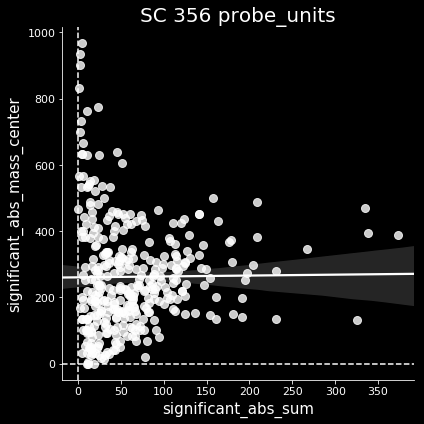

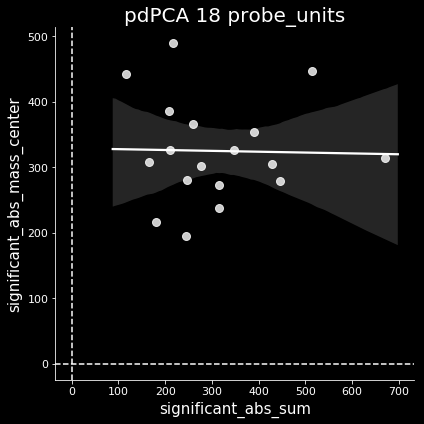

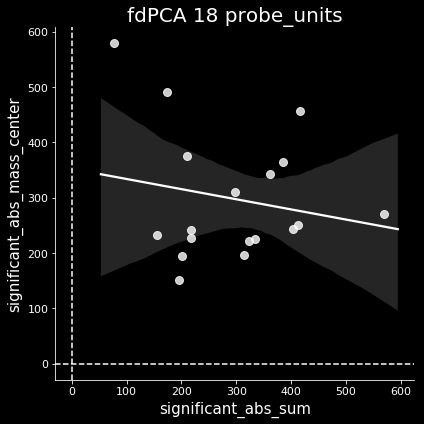

In [16]:
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'
fig, ax = parameter_space_scatter(x, y, analysis='SC')
fig, ax = parameter_space_scatter(x, y, analysis='pdPCA')
fig, ax = parameter_space_scatter(x, y, analysis='fdPCA')

its worth directly comparing parameters between the two dPCA approaches, as seen in the following figure we can presume
that the probe-wise approach leads to slightly greater values of the metric, which is spected, but this difference is not
too great, which further ratifies the full dPCA approach


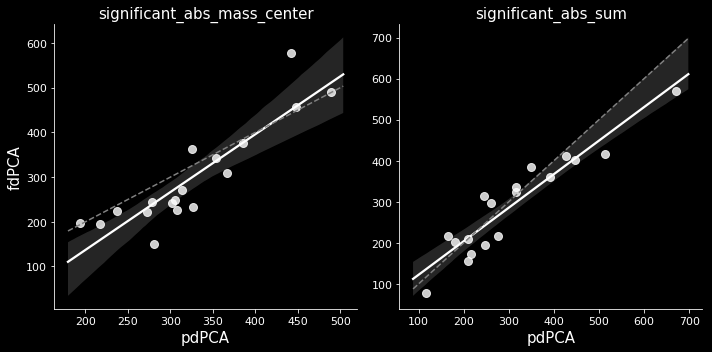

In [17]:
# common parameters
ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_analysis = DF.analysis.isin(['pdPCA','fdPCA'])
ff_source = DF.source == 'dprime'
ff_probe = DF.probe == 'mean'
ff_transpair= DF.transition_pair == 'mean'
ff_good = np.logical_or(DF.goodness > 0.1, DF.goodness.isna()) # empirical good value to filter out garbage cells

filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good, :]
pivoted = filtered.pivot_table(index=['siteid', 'parameter'],
                               columns='analysis', values='value').dropna().reset_index()

g = sns.lmplot(x='pdPCA', y='fdPCA', col='parameter', data=pivoted,
                 sharex=False, sharey=False,
                 scatter_kws={'color':'white'}, line_kws={'color':'white'})
g.set_titles('{col_name}')
g.fig.tight_layout()

for ax in g.axes.flat:
    _ = fplt.unit_line(ax)

distributions of cells/sites in parameter space based on the recorded region

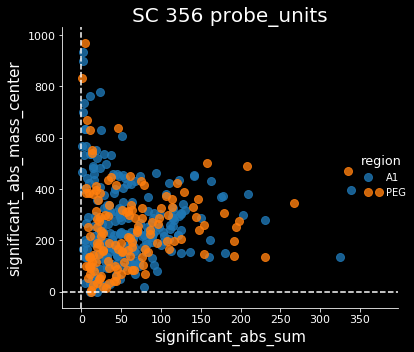

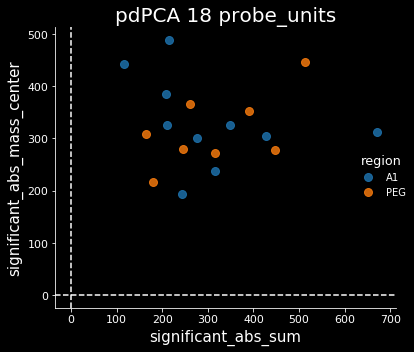

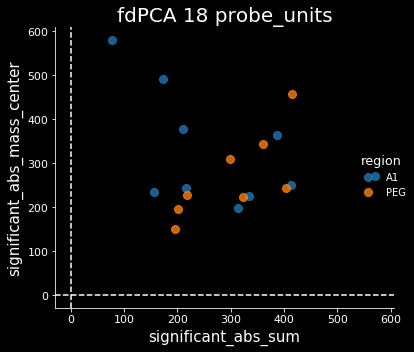

In [18]:
x = 'significant_abs_sum'
y = 'significant_abs_mass_center'
fig, ax = parameter_space_scatter(x, y, analysis='SC', color_regions=True)
fig, ax = parameter_space_scatter(x, y, analysis='pdPCA', color_regions=True)
fig, ax = parameter_space_scatter(x, y, analysis='fdPCA', color_regions=True)

Consider probe_site combinations as independent values for the population analysis

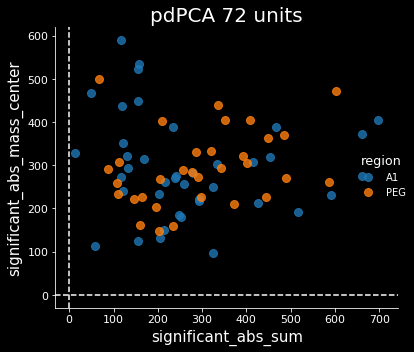

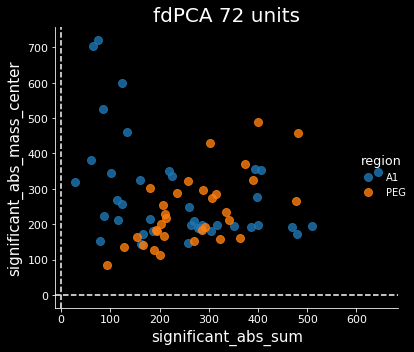

In [19]:
fig, ax = parameter_space_scatter(x, y, analysis='pdPCA', color_regions=True, use_id_probe=True)
fig, ax = parameter_space_scatter(x, y, analysis='fdPCA', color_regions=True, use_id_probe=True)

## 2. different conditions effects on parameters

we can check if there is any systematic effect of probe or transistion pair for our integration and center of mass
metrics, There is no much sense in checking this since the sounds presented are changing from site to site, and there
is no systematic designed difference like in the case of the triplets approach. Non the less I show it here if Stephen
asks

### single cell

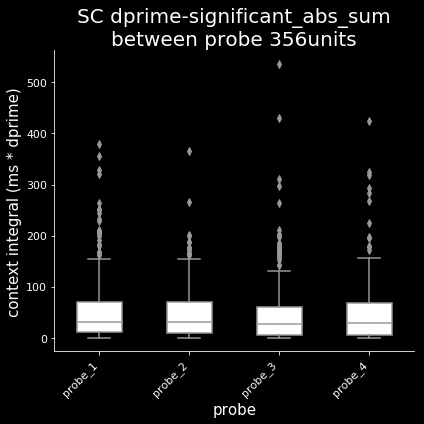

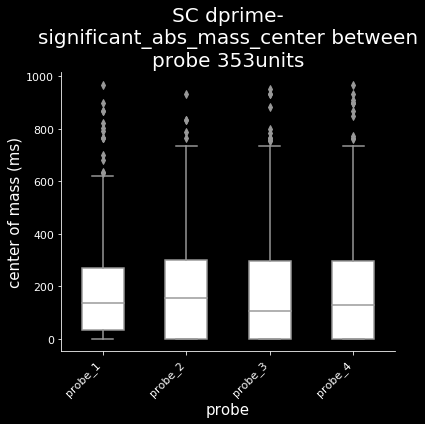

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_3 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.365e-04 stat=1.765e+04
0_1 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.906e-03 stat=1.601e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_3 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.365e-04 stat=1.765e+04
0_1 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.906e-03 stat=1.601e+04


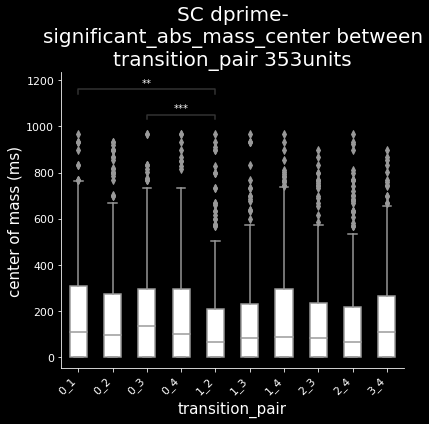

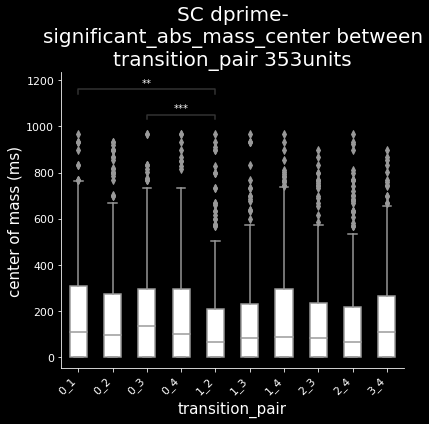

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadcb024710>)

In [20]:
condition_effect_on_parameter(parameter='significant_abs_sum', compare='probe',
                              analysis='SC', nan2zero=True, nozero=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='probe',
                              analysis='SC', nan2zero=True, nozero=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='SC', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='SC', nan2zero=True, nozero=False, use_id_probe=False)

###  pdPCA

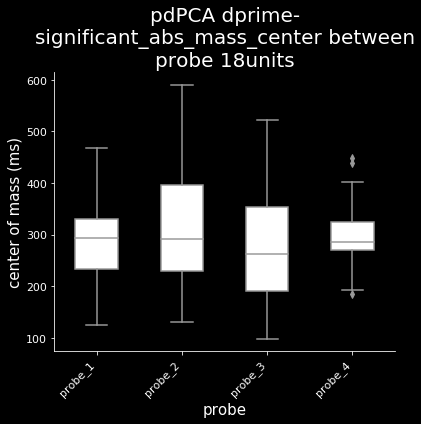

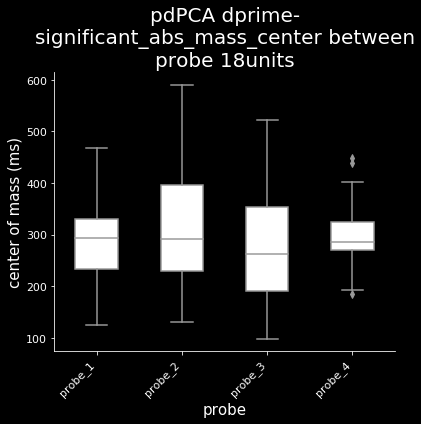

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_4 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.561e-04 stat=1.000e+01
0_4 v.s. 2_3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.090e-03 stat=1.500e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_4 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.561e-04 stat=1.000e+01
0_4 v.s. 2_3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.090e-03 stat=1.500e+01


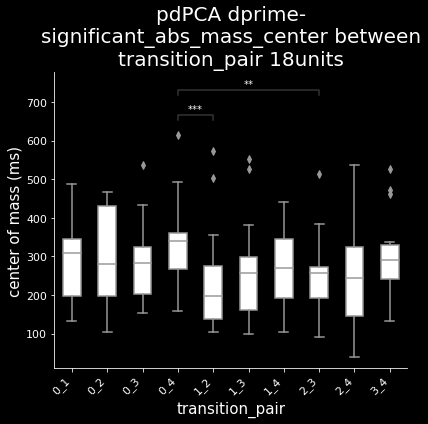

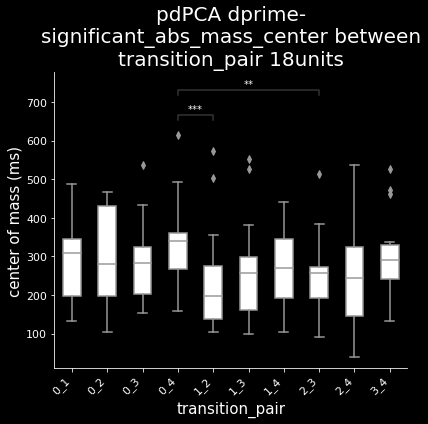

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadd299dc50>)

In [21]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='probe',
                              analysis='pdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='probe',
                              analysis='pdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='pdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='pdPCA', nan2zero=True, nozero=False, use_id_probe=False)

###  fdPCA

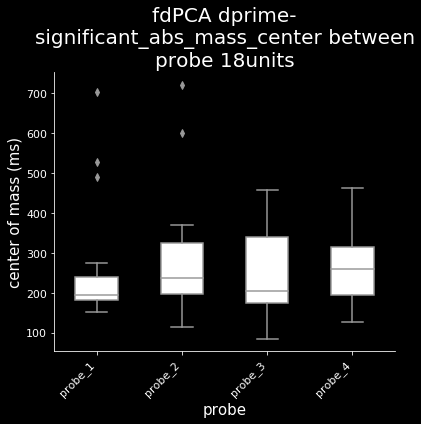

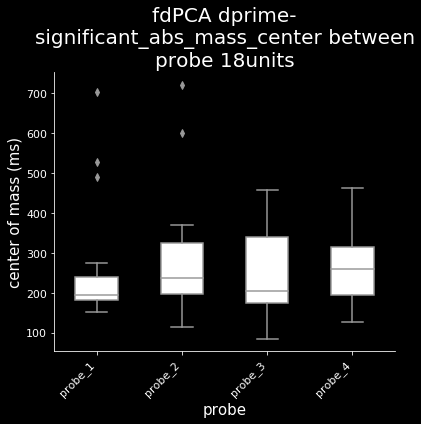

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_4 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.714e-04 stat=1.300e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

0_4 v.s. 1_2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.714e-04 stat=1.300e+01


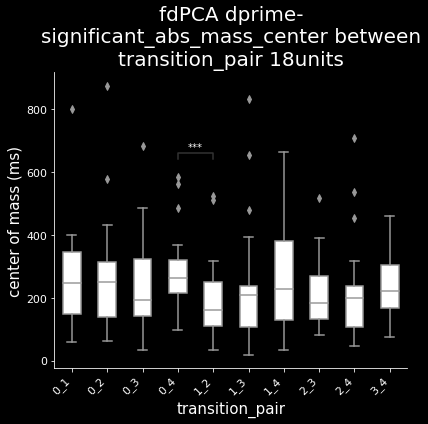

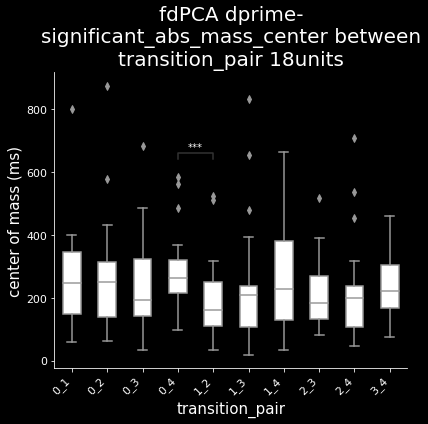

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadd2b0ef98>)

In [22]:
condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='probe',
                              analysis='fdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='probe',
                              analysis='fdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='fdPCA', nan2zero=True, nozero=False, use_id_probe=False)


condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair',
                              analysis='fdPCA', nan2zero=True, nozero=False, use_id_probe=False)

## Python widget with all possible conbinations

In [23]:
interact(condition_effect_on_parameter,
         parameter=['significant_abs_sum', 'significant_abs_mass_center'],
         compare=['probe', 'transition_pair'],
         analysis=['SC', 'pdPCA', 'fdPCA'], source=fixed('dprime'),
         nan2zero=False, nozero=True, use_id_probe=False)

interactive(children=(Dropdown(description='parameter', index=1, options=('significant_abs_sum', 'significant_…

<function __main__.condition_effect_on_parameter(parameter='significant_abs_mass_center', compare='transition_pair', analysis='SC', source='dprime', nan2zero=False, nozero=True, use_id_probe=False)>

# effect of region on metrics

### overview summary plot

In [24]:
def region_metric_comparison(analyses, parameters, y_labels=None, use_id_probes=False, nozeros=True, ax=None):
    # analyses = ('dPCA', )
    # parameters = ('significant_abs_sum', )
    # y_labels=None
    # use_id_probes=False
    # nozeros=True

    ff_parameter = DF.parameter.isin(parameters)
    ff_analysis = DF.analysis.isin(analyses)
    ff_source = DF.source == 'dprime'

    if use_id_probes is True:
        ff_probe = DF.probe != 'mean'
    elif use_id_probes is False:
        ff_probe = DF.probe == 'mean'
    else:
        raise ValueError('use_id_probe must be boolean')

    ff_transpair= DF.transition_pair == 'mean'
    ff_good = DF.value > 0  # empirical good value to filter out garbage cells

    filtered = DF.loc[ff_parameter & ff_analysis & ff_source & ff_probe & ff_transpair & ff_good,
                      ['region', 'id_probe', 'analysis', 'parameter', 'value']]
    if nozeros is True:
        filtered = filtered.loc[filtered.value>0,: ]
    elif nozeros is False:
        pass
    else:
        raise ValueError('nozeros must be bool')

    if len(parameters)>1 or len(analyses)>1:
        g = sns.catplot(x='region', y='value', row='parameter', col='analysis',
                        data=filtered, kind='swarm', dodge=True, sharex=False)
        fig = g.fig
        axes = g.axes
        for row, col in np.ndindex(axes.shape):
            ax = axes[row,col]
            if row == 0:
                ax.set_title(analyses[col])
            else:
                ax.set_title(None)

            if col ==0:
                if y_labels is None:
                    ax.set_ylabel(parameters[row])
                else:
                    ax.set_ylabel(y_labels[parameters[row]])
            else:
                pass
    else:
        if ax is None:
            fig, ax = plt.subplots()

        ax = sns.boxplot(x='region', y='value', data=filtered, ax=ax)
        fig = ax.get_figure()
        # ax = sns.swarmplot(x='region', y='value', data=filtered, ax=ax, dodge=True)

        # no significant comparisons
        box_pairs = [("A1", "PEG")]
        stat_resutls = fplt.add_stat_annotation(ax, data=filtered, x='region', y='value', test='Mann-Whitney',
                                           box_pairs=box_pairs, width=0.5, comparisons_correction='bonferroni')

        ax.set_title(f'{analysis} n={filtered.shape[0]}')
        if y_labels is None:
            ax.set_ylabel(parameters[0])
        else:
            ax.set_ylabel(y_labels[parameters[[0]]])
        axes = ax

    return fig, axes

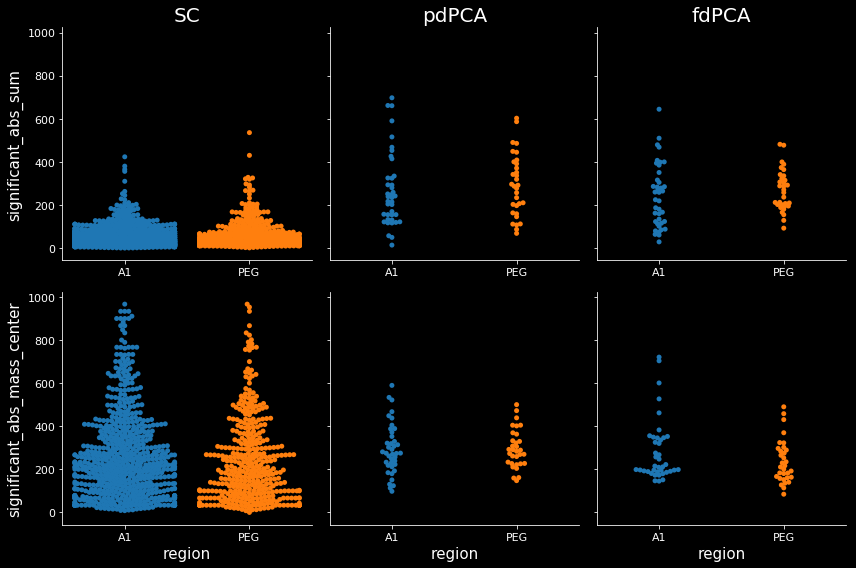

In [25]:
parameters = ['significant_abs_sum', 'significant_abs_mass_center']
analyses = ['SC', 'pdPCA', 'fdPCA']

fig, axes = region_metric_comparison(analyses, parameters, use_id_probes=True, nozeros=True)
fig.set_size_inches([12,8])
fig.tight_layout()

### each subplot with significance tests

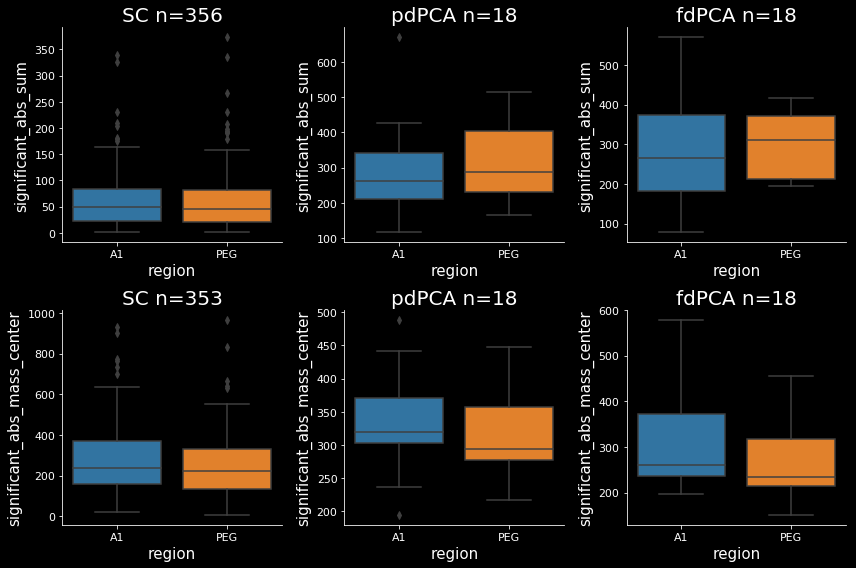

In [26]:
fig, axes = plt.subplots(len(parameters),len(analyses))
for (col, analysis), (row, parameter) in itt.product(enumerate(analyses), enumerate(parameters)):
    region_metric_comparison((analysis,), (parameter,), use_id_probes=False, nozeros=True, ax=axes[row,col])
fig.set_size_inches([12, 8])
fig.tight_layout()

# population and singe unit comparison

In [27]:
def pop_SC_param_comparison(parameter, pop_analysis='pdPCA', nan2zero=False, nozero=True,
                            id_probe=False, color_regions=False):
    # parameter = 'significant_abs_sum'
    # pop_analysis = 'pdPCA'
    # color_regions = True
    # nan2zero=False
    # nozero=True
    # id_probe=True

    if nan2zero:
        cleaned = DF.fillna(value={'value':0})
    elif nan2zero is False:
        cleaned = DF.dropna(axis=0, subset=['value'])
    else:
        raise ValueError('nan2zero not bool')


    # set common filters for single cell and population analysis
    if id_probe:
        ff_probe = cleaned.probe != 'mean'
    else:
        ff_probe = cleaned.probe == 'mean'
    ff_trans = cleaned.transition_pair == 'mean'


    ff_param = cleaned.parameter == parameter
    ff_source = cleaned.source == 'dprime'

    if nozero:
        ff_value = cleaned.value > 0
    elif nozero is False:
        ff_value = cleaned.value >= 0
    else:
        raise ValueError('nozero not bool')

    # Pulls single cell data
    ff_anal = cleaned.analysis == 'SC'
    sing = cleaned.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['siteid', 'cellid', 'region', 'value']]

    sing['site_probe'] =  DF[['siteid', 'probe']].agg('_'.join, axis=1)
    sing_pivot = sing.pivot(index='site_probe', columns='cellid', values='value')
    sing_pivot['agg'] = sing_pivot.max(axis=1)


    # Pulls population data
    ff_anal = DF.analysis == pop_analysis
    pops = DF.loc[ff_anal & ff_probe & ff_trans & ff_param & ff_source & ff_value,
                  ['id_probe', 'region', 'value']]

    pops['site_probe'] = DF['id_probe']
    pops = pops.set_index('site_probe')

    toplot = pd.concat((pops.loc[:, ['region', 'value']], sing_pivot.loc[:, 'agg']), axis=1)

    if color_regions is True:
        g = sns.lmplot(x='value', y='agg', hue='region', data=toplot)
        ax = g.ax
    elif color_regions is False:
        ax = sns.regplot(x='value', y='agg', data=toplot, color='white')
    else:
        raise  ValueError('color_regions must be bool')

    _, _, r2, _, _ = sst.linregress(toplot['value'], toplot['agg'])
    _ = fplt.unit_line(ax, square_shape=False)

    ax.set_xlabel(f'population {parameter}')
    ax.set_ylabel(f'single cell {parameter} max')

    fig = ax.figure
    title = f'SC vs {pop_analysis} {parameter} comparison r={r2:.2f}'
    ax.set_title(fill(title, 35))
    plt.show()

    return fig,ax

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



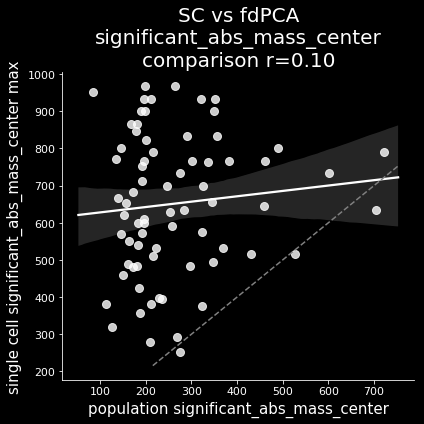

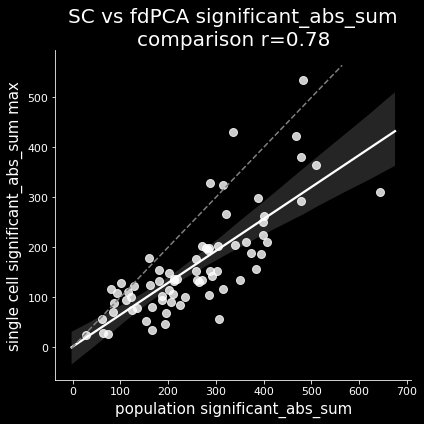

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadd1fe2f60>)

In [28]:
# SC vs dPCA center of mass
pop_SC_param_comparison('significant_abs_mass_center', pop_analysis='fdPCA',  nan2zero=False, nozero=True, id_probe=True)

# SC vs dPCA integral
pop_SC_param_comparison('significant_abs_sum', pop_analysis='fdPCA',  nan2zero=False, nozero=True, id_probe=True)